In [3]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os

# Material constants from Table 4
E = 193000       # MPa
sigma_y = 150    # MPa
c1 = 230000      # MPa
c2 = 19600       # MPa
c3 = 1800        # MPa
gamma1 = 1200
gamma2 = 140
gamma3 = 4
b = 8
Q = 110          # MPastress_values_predicted = calculate_stress_from_plastic_strain(y_pred_denormalized, strain_values_test, material_constants)

# Number of material samples (NLHS) and strain samples (NΔε)
NLHS = 1
NΔε = 1500

# Generate fixed material constants from Table 4
def generate_material_constants(num_samples):
    # Create arrays of constants repeated for num_samples
    E_array = np.full(num_samples, E)
    sigma_y_array = np.full(num_samples, sigma_y)
    c1_array = np.full(num_samples, c1)
    c2_array = np.full(num_samples, c2)
    c3_array = np.full(num_samples, c3)
    gamma1_array = np.full(num_samples, gamma1)
    gamma2_array = np.full(num_samples, gamma2)
    gamma3_array = np.full(num_samples, gamma3)
    b_array = np.full(num_samples, b)
    Q_array = np.full(num_samples, Q)
    
    # Stack them together as columns
    return np.column_stack((E_array, sigma_y_array, c1_array, c2_array, c3_array,
                            gamma1_array, gamma2_array, gamma3_array, b_array, Q_array))


# Generate strain history by accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history

# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update hardening rules
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * np.abs(eps_p_dot)

def update_isotropic_hardening(eps_p_dot, sigma_i, b, Q):
    return b * (Q - sigma_i) * np.abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated

        try:
            delta_gamma = newton(plastic_residual, 1e-5, tol=1e-8, maxiter=50)  # Solve for plastic multiplier
        except RuntimeError:
            delta_gamma = 0  # If Newton-Raphson fails, assume no plastic deformation

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(delta_gamma, sigma_i, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i

def generate_dataset(lb, ub, num_material_samples=1, num_strain_samples=1500):
    material_constants = generate_material_constants(num_material_samples)
    # Generate different strain histories for each sample if desired
    # Or use the same strain history for all samples
    
    dataset = []
    
    for i in range(num_material_samples):
        E, sigma_y = material_constants[i, 0], material_constants[i, 1]
        c = material_constants[i, 2:5]
        gamma = material_constants[i, 5:8]
        b, Q = material_constants[i, 8], material_constants[i, 9]
        
        # Initialize state variables
        sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0
        
        # Generate strain history for each material sample if desired
        strain_history = generate_strain_history(num_strain_samples, lb, ub)
        
        for j in range(num_strain_samples):
            eps = strain_history[j]
            # Elastic predictor
            sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

            # Run the return mapping algorithm
            sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
                eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
                c[0], c[1], c[2], gamma[0], gamma[1], gamma[2], b, Q, E, sigma_y
            )
            

            # Calculate trial phi (trialϕ)
            #trial_phi = np.abs(sigma_trial) - sigma_y
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            trial_phi = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)

            
            # Compute stress using the return mapping algorithm
            stress_rm = sigma_updated  # Stress from Return Mapping

            # Store the strain and stress
            dataset.append([
                E, sigma_y, c[0],gamma[0], c[1],gamma[1], c[2],gamma[2],
                b, Q, trial_phi,
                eps,          # Strain
                stress_rm,    # Stress from Return Mapping
                np.abs(eps_p)
                #round(eps_p, 5)         # Plastic strain
            ])
    dataset = np.array(dataset)
    return dataset


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training_check.csv"):
    columns = ['E', 'sigma_y', 'c1', 'c2', 'c3',
               'gamma1', 'gamma2', 'gamma3',
               'b', 'Q','trial_phi', 'strain', 'stress_rm', 'plastic_strain']
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")

# Normalize the dataset
def normalize_dataset(data, scaler=None):
    if scaler is None:
        scaler = MinMaxScaler()
        normalized_data = scaler.fit_transform(data)
    else:
        normalized_data = scaler.transform(data)
    return normalized_data, scaler



# Split dataset into training and testing sets
def split_dataset(X, y):
    return train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network
def build_model(input_dim):
    model = Sequential([
        #Dense(100, activation='sigmoid', input_shape=(input_dim,)),  # Use 10 neurons, sigmoid activation
        #Dense(500, activation='sigmoid', input_shape=(input_dim,)),  # Use 10 neurons, sigmoid activation
        Dense(5, activation='sigmoid'),  # Second hidden layer also with 10 neurons
        Dense(1, activation='linear')     # Linear activation for the output
    ])
    custom_adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=custom_adam, loss='mean_squared_error', metrics=['mae'])
    return model

# Plot training and validation loss
def plot_loss(history, filename='loss_curve.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    #plt.savefig(filename)  # Save the plot as an image file
    #plt.close()  # Close the plot to avoid displaying it in the notebook
    #print(f"Loss curve saved as {filename}")

# Plot predicted vs original values
def plot_predicted_vs_actual(y_test, y_pred, filename='predicted_vs_actual.png'):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Original Values', color='blue')
    plt.plot(y_pred, label='Predicted Values', color='red', linestyle='--')
    plt.xlabel('Sample index')
    plt.ylabel('Plastic Strain')
    plt.title('Predicted vs. Original Plastic Strain')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.savefig('predicted_vs_actual')  # Save the plot as an image file
    plt.close()  # Close the plot to avoid displaying it in the notebookLHSLHS
    print(f"Plot saved as {'predicted_vs_actual'}")


In [4]:
# Generate training dataset
print("Generating training dataset...")
training = generate_dataset(lb=0.0001, ub=0.0002, num_material_samples=NLHS, num_strain_samples=NΔε)

Generating training dataset...


In [5]:
test1 = generate_dataset(lb=0, ub=0.0001, num_material_samples=NLHS, num_strain_samples=NΔε)

In [6]:
test2 = generate_dataset(lb=0.0002, ub=0.0004, num_material_samples=NLHS, num_strain_samples=NΔε)

In [7]:
training[90]

array([1.93000000e+05, 1.50000000e+02, 2.30000000e+05, 1.20000000e+03,
       1.96000000e+04, 1.40000000e+02, 1.80000000e+03, 4.00000000e+00,
       8.00000000e+00, 1.10000000e+02, 2.64818495e+01, 1.37915047e-02,
       3.76825512e+02, 1.18390409e-02])

In [8]:
# Separate features and target
X = training[:, : -3]  # Features (E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q, strain)
y = training[:, -1]   # Targets (plastic_strain)

In [9]:
# Normalize the dataset
print("Normalizing the dataset...")
X_normalized, scaler_X = normalize_dataset(X)
#X_normalized=X
y = y.reshape(-1, 1)
y_normalized, scaler_y = normalize_dataset(y)
#y_normalized = y

# Split the dataset into training and testing sets
print("Splitting the dataset into training and testing sets...")
X_train, X_test, y_train, y_test = split_dataset(X_normalized, y_normalized)

# Build the neural network model
print("Building the neural network model...")
model = build_model(X_train.shape[1])

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=50,                # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True   # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model with early stopping
print("Training the model...")
history = model.fit(
    X_train, 
    y_train, 
    epochs=1000,               # Set a large number of epochs
    batch_size=1000,
    validation_split=0.2, 
    callbacks=[early_stopping],  # Include the early stopping callback
    verbose=1
)

Normalizing the dataset...
Splitting the dataset into training and testing sets...
Building the neural network model...
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Training the model...
Train on 960 samples, validate on 240 samples
Epoch 1/1000
960/960 [==============================] - 0s 129us/sample - loss: 0.2214 - mean_absolute_error: 0.3843 - val_loss: 0.1943 - val_mean_absolute_error: 0.3623
Epoch 2/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.2182 - mean_absolute_error: 0.3810 - val_loss: 0.1912 - val_mean_absolute_error: 0.3592
Epoch 3/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.2149 - mean_absolute_error: 0.3778 - val_loss: 0.1882 - val_mean_absolute_error: 0.3562
Epoch 4/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.2117 - mean_absolute_error: 0.3747 - val_loss: 0.1852 - val_mean_absolute_error: 0.3533
Epoch 5/1000
960/960

Epoch 47/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.1194 - mean_absolute_error: 0.2843 - val_loss: 0.1004 - val_mean_absolute_error: 0.2656
Epoch 48/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.1182 - mean_absolute_error: 0.2832 - val_loss: 0.0994 - val_mean_absolute_error: 0.2645
Epoch 49/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.1171 - mean_absolute_error: 0.2821 - val_loss: 0.0984 - val_mean_absolute_error: 0.2635
Epoch 50/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.1160 - mean_absolute_error: 0.2811 - val_loss: 0.0974 - val_mean_absolute_error: 0.2625
Epoch 51/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.1149 - mean_absolute_error: 0.2801 - val_loss: 0.0965 - val_mean_absolute_error: 0.2615
Epoch 52/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.1139 - mean_absolute_error: 0.2791 - val_loss: 0.0956 - val_mean_absolute_

Epoch 96/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0924 - mean_absolute_error: 0.2593 - val_loss: 0.0782 - val_mean_absolute_error: 0.2397
Epoch 97/1000
960/960 [==============================] - 0s 3us/sample - loss: 0.0922 - mean_absolute_error: 0.2592 - val_loss: 0.0781 - val_mean_absolute_error: 0.2395
Epoch 98/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0921 - mean_absolute_error: 0.2591 - val_loss: 0.0780 - val_mean_absolute_error: 0.2393
Epoch 99/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0919 - mean_absolute_error: 0.2590 - val_loss: 0.0780 - val_mean_absolute_error: 0.2392
Epoch 100/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0918 - mean_absolute_error: 0.2589 - val_loss: 0.0779 - val_mean_absolute_error: 0.2390
Epoch 101/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0917 - mean_absolute_error: 0.2588 - val_loss: 0.0778 - val_mean_absolut

Epoch 145/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0897 - mean_absolute_error: 0.2574 - val_loss: 0.0771 - val_mean_absolute_error: 0.2377
Epoch 146/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0897 - mean_absolute_error: 0.2574 - val_loss: 0.0771 - val_mean_absolute_error: 0.2377
Epoch 147/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0897 - mean_absolute_error: 0.2574 - val_loss: 0.0771 - val_mean_absolute_error: 0.2377
Epoch 148/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0897 - mean_absolute_error: 0.2574 - val_loss: 0.0771 - val_mean_absolute_error: 0.2377
Epoch 149/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0897 - mean_absolute_error: 0.2574 - val_loss: 0.0771 - val_mean_absolute_error: 0.2377
Epoch 150/1000
960/960 [==============================] - 0s 2us/sample - loss: 0.0897 - mean_absolute_error: 0.2574 - val_loss: 0.0772 - val_mean_abs

Evaluating the model on the test set...
Test MAE: 0.255964457988739
Making predictions on the test set...
Model saved as 'plastic_strain_predictor_model.h5'


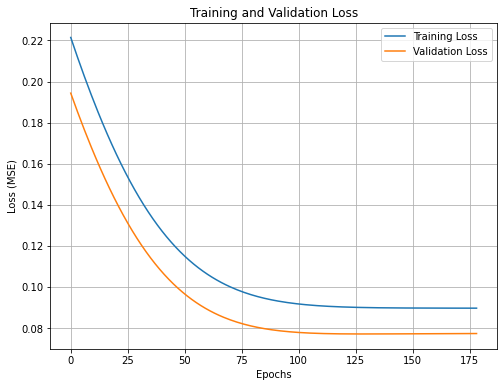

In [10]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MAE: {test_mae}")

# Make predictionsarr_reduced = arr[0, :]
print("Making predictions on the test set...")
y_pred_normalized = model.predict(X_test)

# Denormalize predictions and actual values
y_pred_denormalized = scaler_y.inverse_transform(y_pred_normalized).flatten()
y_test_denormalized = scaler_y.inverse_transform(y_test).flatten()

# Save the model
model.save('plastic_strain_predictor_model.h5')
print("Model saved as 'plastic_strain_predictor_model.h5'")

# Plot training and validation loss
plot_loss(history, filename='loss_curve.png')

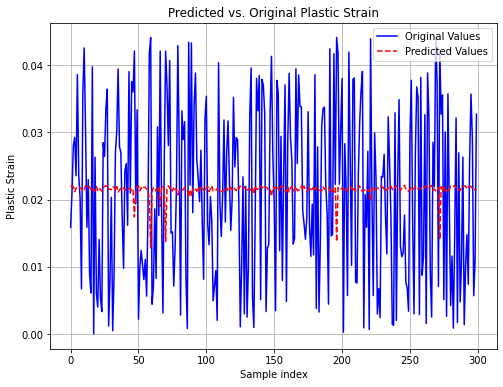

Plot saved as predicted_vs_actual


In [11]:
# Plot predicted vs original plastic strain
plot_predicted_vs_actual(y_test_denormalized, y_pred_denormalized, filename='predicted_vs_actual.png')
#plot_predicted_vs_actual(y_test, y_pred_de, filename='predicted_vs_actual.png')

In [12]:
# Function to calculate stress from predicted plastic strain values using return mapping
def calculate_stress_from_plastic_strain(plastic_strain_values, strain_values, material_constants):
    # Unpack material constants
    E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q = material_constants
    
    # Initialize variables for kinematic and isotropic hardening
    sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0
    
    stress_values = []
    
    # Loop through each strain and corresponding predicted plastic strain
    for i in range(len(plastic_strain_values)):
        eps_p_nn = plastic_strain_values[i]  # Predicted plastic strain from the neural network
        eps = strain_values[i]               # Total strain (input strain)
        
        # Elastic predictor step
        sigma_trial, yield_function = elastic_predictor(eps, eps_p_nn, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

        if yield_function <= 0:
            sigma_updated=sigma_trial
        else:      
            # Return mapping algorithm to calculate final stress
            sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            eps, eps_p_nn, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, 
            c1, c2, c3, gamma1, gamma2, gamma3, b, Q, E, sigma_y)

        # Append the updated stress value to the list
        stress_values.append(sigma_updated)
    
    return np.array(stress_values)


In [13]:

# Get strain values from the test set (or use the
# Define material constants (same as those used for training)
material_constants = [E, sigma_y, c1, c2, c3, gamma1, gamma2, gamma3, b, Q]

# Get strain values from the test set (or use the strain values corresponding to the predicted plastic strain)
strain_values_test = training[:, 11]  # Assuming the last column of X_test is the strain values

y_pred_normalized_nn = np.abs(model.predict(X_normalized))
#y_pred_normalized_nn = training[:,-1]
y_pred_normalized_nn = np.squeeze(y_pred_normalized_nn)


#stress_values_predicted = calculate_stress_from_plastic_strain(y_pred_normalized_nn, strain_values_test, material_constants)
stress_values_predicted =(strain_values_test - y_pred_normalized_nn)

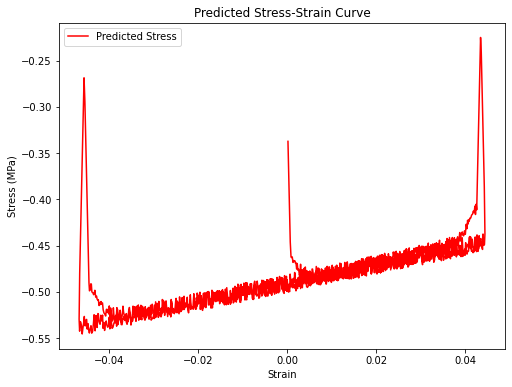

In [14]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
#plt.plot(strain_values_test, training[:,-2], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

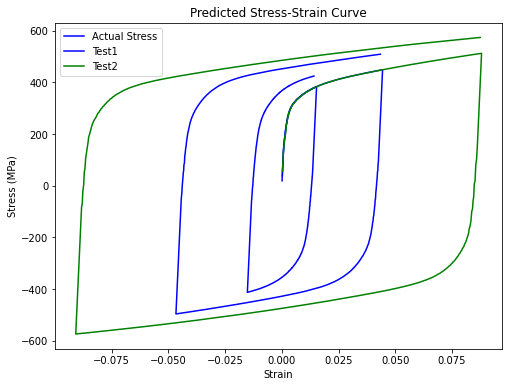

In [16]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
#plt.plot(strain_values_test, stress_values_predicted, label='Predicted Stress', color='red')
plt.plot(strain_values_test, training[:,-2], label='Actual Stress', color='blue')
plt.plot(test1[:,-3], test1[:,-2], label='Test1', color='blue')
plt.plot(test2[:,-3], test2[:,-2], label='Test2', color='green')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()